Load files

In [1]:
cat_set = "/content/drive/MyDrive/Pets/cat"
dog_set = "/content/drive/MyDrive/Pets/dog"

Assigning Target column 1 to cats and 0 to dogs files

In [2]:
import os
import pandas as pd
import numpy as np

# List the files in the directories
img_cat = [os.path.join(cat_set, file) for file in os.listdir(cat_set)[:1000]]
img_dog = [os.path.join(dog_set, file) for file in os.listdir(dog_set)[:1000]]

cat_df = pd.DataFrame({"image_path": img_cat, "Target": 1})
dog_df = pd.DataFrame({"image_path": img_dog, "Target": 0})
print(len(cat_df), len(dog_df))

1000 1000


Concatenate dog and cat files and shuffle them.

In [3]:
# Concatenate the dataframes
cat_dog_df = pd.concat([cat_df, dog_df], ignore_index=True)

# Shuffle the combined dataframes
cat_dog_df = cat_dog_df.sample(frac=1).reset_index(drop=True)
cat_dog_df.head()

,image_path,Target
0,/content/drive/MyDrive/Pets/dog/768.jpg,0
1,/content/drive/MyDrive/Pets/dog/4777.jpg,0
2,/content/drive/MyDrive/Pets/dog/987.jpg,0
3,/content/drive/MyDrive/Pets/dog/4683.jpg,0
4,/content/drive/MyDrive/Pets/dog/4654.jpg,0


Functions to preprocessing images in HSV, HOG, RGB, LAB features

In [4]:
from skimage.feature import hog
from skimage import io, color, transform, exposure
import numpy as np
import matplotlib.pyplot as plt
import cv2

#performing HSV, applying HOG over Value component
def hsv_hog_features(img_path, resize_dim=(128, 128), pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    try:
        # Read the image
        image = io.imread(img_path)

        # Resize the image
        img_resized = transform.resize(image, resize_dim, anti_aliasing=True)

        # Convert the image to HSV
        image_hsv = color.rgb2hsv(img_resized)

        # Separate the HSV channels
        hue_channel = image_hsv[:, :, 0]
        saturation_channel = image_hsv[:, :, 1]
        value_channel = image_hsv[:, :, 2]

        orientations = 9

        hog_features = hog(value_channel,
                          orientations=orientations,
                          pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block,
                          block_norm='L2-Hys',
                          visualize=False)

        return hue_channel, saturation_channel, hog_features

    except Exception as e:
        print(f"Error in image {img_path}: {str(e)}")
        return None, None, None


#performing RGB on resized image
def RGB_features(img_path, resize_dim=(128, 128)):
    try:
        # Read the image
        image = io.imread(img_path)

        # Resize the image
        img_resized = transform.resize(image, resize_dim, anti_aliasing=True)
        # Split the image into color channels
        red_channel = image[:, :, 0]
        green_channel = image[:, :, 1]
        blue_channel = image[:, :, 2]
        return red_channel, green_channel, blue_channel

    except Exception as e:
        print(f"Error in image {img_path}: {str(e)}")
        return None, None, None


#performing RGB on resized image as flattened features
def flattened_RGB_features(img_path, resize_dim=(128, 128)):
    try:
        # Read the image
        image = io.imread(img_path)

        # Resize the image
        img_resized = transform.resize(image, resize_dim, anti_aliasing=True)

        # Flatten the RGB channels
        red_channel = img_resized[:, :, 0].flatten()
        green_channel = img_resized[:, :, 1].flatten()
        blue_channel = img_resized[:, :, 2].flatten()

        return red_channel, green_channel, blue_channel

    except Exception as e:
        print(f"Error in image {img_path}: {str(e)}")
        return None, None, None



#performing LAB on resized image
def LAB_features(img_path, resize_dim=(128, 128)):
    try:
        # Read the image
        image = io.imread(img_path)

        # Resize the image
        img_resized = transform.resize(image, resize_dim, anti_aliasing=True)

        lab_image = color.rgb2lab(img_resized)

        # Split the LAB image into its components
        L_channel = lab_image[:, :, 0].flatten()
        A_channel = lab_image[:, :, 1].flatten()
        B_channel = lab_image[:, :, 2].flatten()


        return L_channel, A_channel, B_channel

    except Exception as e:
        print(f"Error in image {img_path}: {str(e)}")
        return None, None, None

Getting the HSV channels and filling error files with "None" to be cleaned.

In [17]:
# Define a function to calculate the features and assign them to the corresponding columns
def calculate_hsv_hog_features(img_path):
    if img_path is not None:
        hue_features, sat_features, hog_features = hsv_hog_features(img_path)
        return hue_features, sat_features, hog_features
    else:
        return None, None, None

# Apply the function to each row of 'image_path' and assign the results to the corresponding columns
cat_dog_df['hue_features'], cat_dog_df['sat_features'], cat_dog_df['hog_features'] = zip(*cat_dog_df['image_path'].apply(calculate_hsv_hog_features))


Getting the RGB channels

In [18]:
# Apply the function to each row of 'image_path' and assign the results to the corresponding columns
cat_dog_df['red_channel'], cat_dog_df['green_channel'], cat_dog_df['blue_channel'] = zip(*cat_dog_df['image_path'].apply(RGB_features))


Getting the RGB channels to be flattened

In [19]:
# Apply the function to each row of 'image_path' and assign the results to the corresponding columns
cat_dog_df['fl_red_channel'], cat_dog_df['fl_green_channel'], cat_dog_df['fl_blue_channel'] = zip(*cat_dog_df['image_path'].apply(lambda x: flattened_RGB_features(x, resize_dim=(160, 160))))


Getting the LAB channels

In [20]:
# Apply the function to each row of 'image_path' and assign the results to the corresponding columns
cat_dog_df['L_channel'], cat_dog_df['A_channel'], cat_dog_df['B_channel'] = zip(*cat_dog_df['image_path'].apply(lambda x: LAB_features(x, resize_dim=(160, 160))))


In [21]:
cat_dog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_path        2000 non-null   object
 1   Target            2000 non-null   int64 
 2   hue_features      2000 non-null   object
 3   sat_features      2000 non-null   object
 4   hog_features      2000 non-null   object
 5   red_channel       2000 non-null   object
 6   green_channel     2000 non-null   object
 7   blue_channel      2000 non-null   object
 8   fl_red_channel    2000 non-null   object
 9   fl_green_channel  2000 non-null   object
 10  fl_blue_channel   2000 non-null   object
 11  L_channel         2000 non-null   object
 12  A_channel         2000 non-null   object
 13  B_channel         2000 non-null   object
dtypes: int64(1), object(13)
memory usage: 218.9+ KB


Dropping rows with None elements

In [22]:
cat_dog_df.dropna(inplace=True)

Hue Saturation and (Value+HOG) histograms

In [23]:
hue_features_hist = np.array([np.histogram(image, bins=20)[0] for image in cat_dog_df['hue_features']])
sat_features_hist = np.array([np.histogram(image, bins=20)[0] for image in cat_dog_df['sat_features']])
val_features_hist = np.array([np.histogram(image, bins=20)[0] for image in cat_dog_df['hog_features']])

hue_features_hist.shape, sat_features_hist.shape, val_features_hist.shape

((2000, 20), (2000, 20), (2000, 20))

Hue, Saturation and (Value+HOG) flattened

In [24]:
hue_features = np.array(cat_dog_df['hue_features'].tolist()).reshape(-1, 160*160)
sat_features = np.array(cat_dog_df['sat_features'].tolist()).reshape(-1, 160*160)
hog_features = np.array(cat_dog_df['hog_features'].tolist())

hue_features.shape, sat_features.shape, hog_features.shape

((1280, 25600), (1280, 25600), (2000, 8100))

RGB Histogram

In [25]:
# Extract the histogram features
red_features_hist = np.array([np.histogram(image, bins=20)[0] for image in cat_dog_df['red_channel']])
green_features_hist = np.array([np.histogram(image, bins=20)[0] for image in cat_dog_df['green_channel']])
blue_features_hist = np.array([np.histogram(image, bins=20)[0] for image in cat_dog_df['blue_channel']])

red_features_hist.shape, green_features_hist.shape, blue_features_hist.shape

((2000, 20), (2000, 20), (2000, 20))

RGB flattened

In [26]:
# Extract and flatten the features
red_features = np.vstack(cat_dog_df['fl_red_channel'].to_numpy())
green_features = np.vstack(cat_dog_df['fl_green_channel'].to_numpy())
blue_features = np.vstack(cat_dog_df['fl_blue_channel'].to_numpy())

red_features.shape, green_features.shape, blue_features.shape

((2000, 25600), (2000, 25600), (2000, 25600))

LAB (CIELAB) flattened

In [27]:
# Extract and flatten the features
L_features = np.vstack(cat_dog_df['L_channel'].to_numpy())
A_features = np.vstack(cat_dog_df['A_channel'].to_numpy())
B_features = np.vstack(cat_dog_df['B_channel'].to_numpy())

L_features.shape, A_features.shape, B_features.shape

((2000, 25600), (2000, 25600), (2000, 25600))

Seleccting X and y variables from dataset

In [28]:
X = hog_features#np.hstack((red_features_hist, green_features_hist, blue_features_hist))
y = cat_dog_df["Target"]

# Reshape X to a 2D array
X = X.reshape(X.shape[0], -1)

# Display the shape of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2000, 8100)
y shape: (2000,)


Splitting 5% testing, 10% validation from 95% training

In [82]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets (95% training, 5% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Split the training data into training and validation sets (85% training, 10% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.105, random_state=42)

print("X training:", X_train.shape)
print("X test:", X_test.shape)
print("X validation:", X_val.shape)


X training: (1700, 8100)
X test: (100, 8100)
X validation: (200, 8100)


In [81]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage.filters import prewitt_h, prewitt_v
from skimage.morphology import closing, square
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Perform best dimensional reduction PCA
def best_pca(X):
    pca = PCA()
    X_pca = pca.fit_transform(X)

    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
    plt.grid(True)
    plt.show()
    return

#perform best SVC
def best_svc(n_components, X_train, X_val, y_train, y_val):
    # Define the pipeline with a scaler, PCA, and SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components)),
        ('svc', SVC())
    ])

    # Define the parameter grid
    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000],  # Values for C
        'svc__gamma': [0.001, 0.01, 0.1, 1, 10]  # Values for gamma
    }

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Evaluate the model on the test set
    accuracy = grid_search.score(X_val, y_val)
    print("Validation Accuracy:", accuracy)
    return


#perform best Random Forest
def best_rf(X_train, X_val, y_train, y_val):
    # Define the parameter grid
    param_grid = {
            'n_estimators': [100, 250, 500],
            'max_depth': [None, 5, 10, 20],
            'criterion': ['gini', 'entropy']
            }

    # Instantiate the Random Forest classifier
    rf_classifier = RandomForestClassifier()

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Evaluate the model on the test set
    accuracy = grid_search.score(X_val, y_val)
    print("Validation Accuracy:", accuracy)
    return



#perform best KNN
def best_knn(n_components, X_train, X_val, y_train, y_val):
    # Define the pipeline
    pipe_spm = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('pca', PCA(n_components)),  # Dimensionality reduction
        ('knn', KNeighborsClassifier())  # KNN
    ])
    # Define the parameter grid to search
    param_grid = {
    'knn__n_neighbors': [2, 3, 5, 7],  # Number of neighbors for kNN
    'knn__weights': ['uniform', 'distance']  # Weighting method for kNN
    }
    # Setup the grid search with cross-validation
    grid_search = GridSearchCV(pipe_spm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform the grid search on the training data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_pipeline = grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Evaluate the model on the test set
    accuracy = best_pipeline.score(X_val, y_val)
    print("Accuracy on the validation set:", accuracy)

    return

Applying Standar Scaler

In [69]:
ssc = StandardScaler()
X_scaled = ssc.fit_transform(X_train)

Performing the best PCA

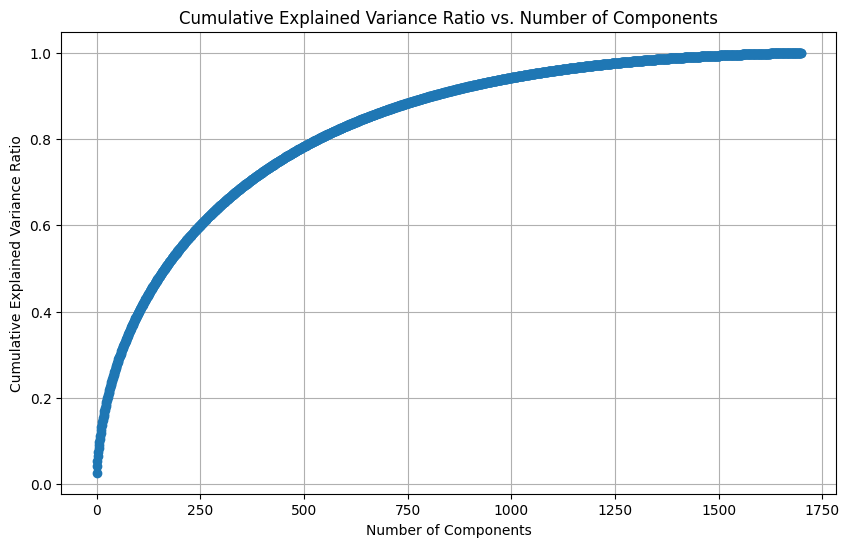

In [32]:
best_pca(X_scaled)

In [70]:
n_components = 100

Performing Grid Research for tunning best SVC paramenters

In [71]:
best_svc(n_components, X_train, X_val, y_train, y_val)

Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}
Best Score: 0.7041176470588236
Validation Accuracy: 0.72


Performing Grid Research for tunning best Random Forest paramenters

In [83]:
best_rf(X_train, X_val, y_train, y_val)

KeyboardInterrupt: 

Performing Grid Research for tunning best KNN paramenters

In [ ]:
best_knn(n_components, X_train, X_val, y_train, y_val)

Setting pipelines with ML classifiers best parameters


In [53]:
# Define base classifiers with preprocessing
pipe_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('svc', SVC(C=100, gamma=0.001, kernel='rbf', probability=True))
])

rf_classifier = RandomForestClassifier(n_estimators=500,
                                       max_depth=10,
                                       criterion='gini')

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),  # Dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))  # KNN
])


performing ROC AUC on SVC, KNN, and RF

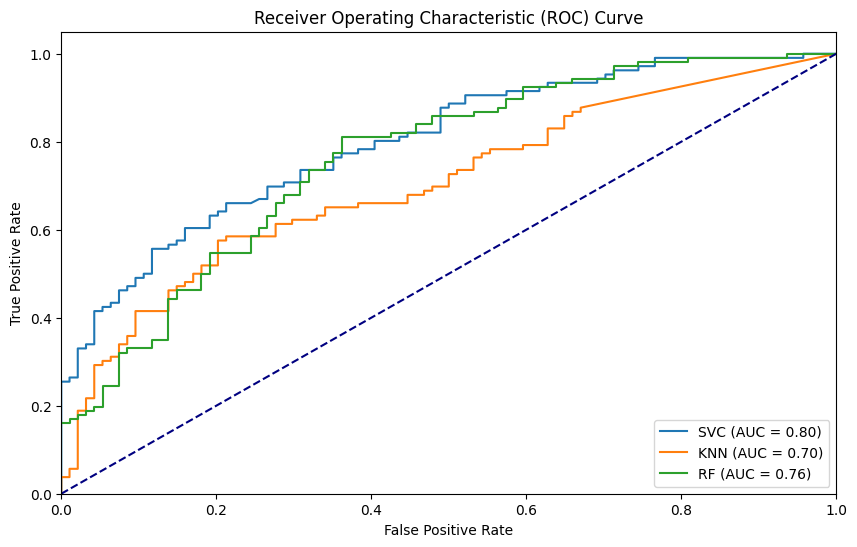

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Define base classifiers with preprocessing
n_components = 100  # Define the number of components for PCA
pipe_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('svc', SVC(C=100, gamma=0.001, kernel='rbf', probability=True))
])

rf_classifier = RandomForestClassifier(n_estimators=500,
                                       max_depth=10,
                                       criterion='gini')

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),  # Dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))  # KNN
])

# Combine classifiers into a dictionary
classifiers = {'SVC': pipe_SVC, 'KNN': pipe_knn, 'RF': rf_classifier}

plt.figure(figsize=(10, 6))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Performing an independent ROC AUC over three pipeline classifiers.

In [41]:
from sklearn.model_selection import cross_val_score

# Define the list of classifiers and their corresponding labels
classifiers = [pipe_SVC, pipe_knn, rf_classifier ]
clf_labels = ['SVC', 'kNN', 'Random Forest']

# Perform 10-fold cross-validation for each classifier
for clf, label in zip(classifiers, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


ROC AUC: 0.79 (+/- 0.02) [SVC]
ROC AUC: 0.68 (+/- 0.03) [kNN]
ROC AUC: 0.75 (+/- 0.02) [Random Forest]


Majority Voting

In [54]:
from sklearn.ensemble import VotingClassifier


# Create a voting classifier using majority voting
voting_clf = VotingClassifier(
    estimators=[('svc', pipe_SVC), ('rf', rf_classifier), ('knn', pipe_knn)],
    voting='soft'  # Use 'hard' voting for majority voting
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_val_pred_voting = voting_clf.predict(X_val)

# Calculate accuracy
accuracy_voting = accuracy_score(y_val, y_val_pred_voting)
print("Accuracy using majority voting:", accuracy_voting)

Accuracy using majority voting: 0.69


Applying Gradient Boosting Classifier

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier


# Define the meta-classifier (Gradient Boosting Machine)
gbm = GradientBoostingClassifier()

# Create the stacking ensemble
estimators = [('svc', pipe_SVC), ('rf', rf_classifier), ('knn', pipe_knn)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=gbm)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_val_pred = stacking_clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy:", accuracy)

Accuracy: 0.695


Perform ROC_AUC on Mojority Voting Classifier (validation)

In [57]:
from sklearn.metrics import roc_auc_score

y_test_pred = voting_clf.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print("ROC-AUC score on test set:", roc_auc_test)

ROC-AUC score on test set: 0.712121212121212


Perform ROC_AUC on Gradient Boosting Classifier (test)

In [58]:
from sklearn.metrics import roc_auc_score

y_test_pred = stacking_clf.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print("ROC-AUC score on test set:", roc_auc_test)

ROC-AUC score on test set: 0.7151515151515151


Performing ROC AUC on test set with two ensembling methods

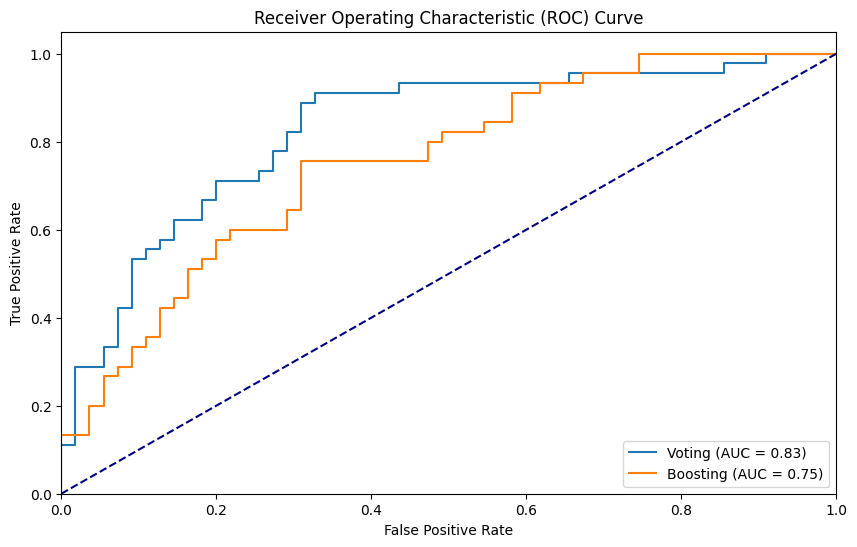

In [59]:
# Combine classifiers into a dictionary
classifiers = {'Voting': voting_clf, 'Boosting': stacking_clf}

plt.figure(figsize=(10, 6))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


RGB decomposition

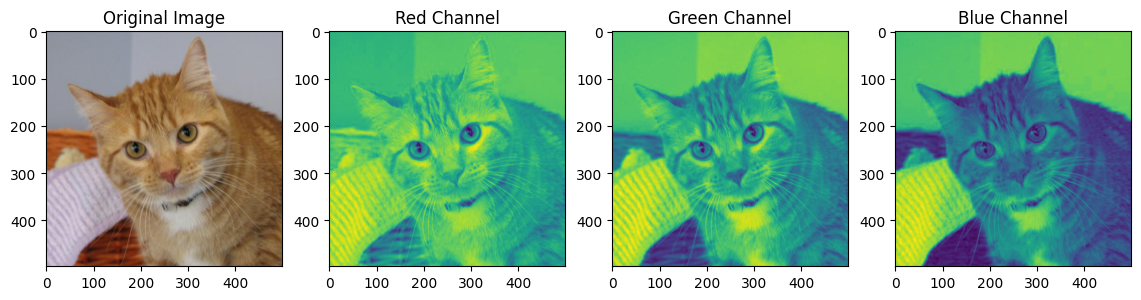

In [ ]:
from skimage.feature import hog
from skimage import io, color
import numpy as np
import matplotlib.pyplot as plt

# Load a color image
image = io.imread('/content/cat/194.jpg')

# Split the image into color channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Show the results
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')

axes[1].imshow(red_channel)
axes[1].set_title('Red Channel')

axes[2].imshow(green_channel)
axes[2].set_title('Green Channel')

axes[3].imshow(blue_channel)
axes[3].set_title('Blue Channel')

plt.show()

RGB Histogram

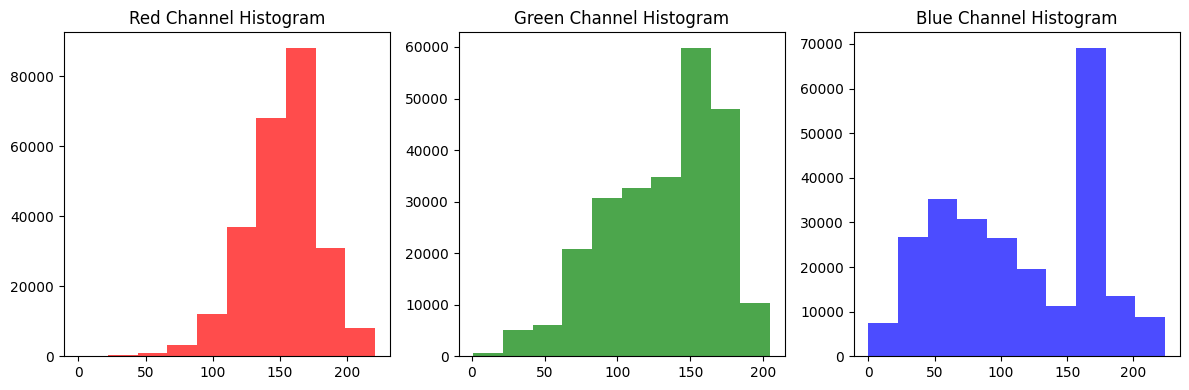

In [ ]:
# Plot histograms for each channel with 10 bins
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(red_channel.ravel(), bins=10, color='red', alpha=0.7)
axes[0].set_title('Red Channel Histogram')

axes[1].hist(green_channel.ravel(), bins=10, color='green', alpha=0.7)
axes[1].set_title('Green Channel Histogram')

axes[2].hist(blue_channel.ravel(), bins=10, color='blue', alpha=0.7)
axes[2].set_title('Blue Channel Histogram')

plt.tight_layout()
plt.show()

HOG applied on HSV image

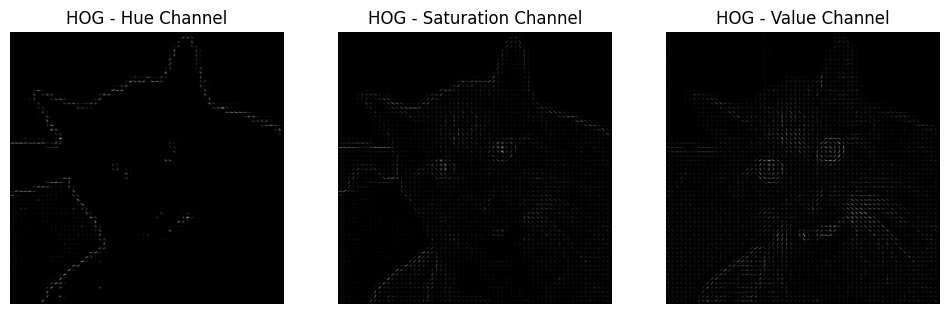

In [ ]:
from skimage.feature import hog
from skimage import io, color, exposure
import numpy as np
import matplotlib.pyplot as plt

# Load a color image
image = io.imread('/content/cat/194.jpg')

# Convert the image to HSV
image_hsv = color.rgb2hsv(image)

# Split the HSV image into its components (Hue, Saturation, Value)
hue_channel = image_hsv[:, :, 0]
saturation_channel = image_hsv[:, :, 1]
value_channel = image_hsv[:, :, 2]

# Parameters for HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (1, 1)

# Compute HOG for each component of the HSV color space
hog_hue, hog_hue_image = hog(hue_channel, orientations=orientations, pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)
hog_saturation, hog_saturation_image = hog(saturation_channel, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                          cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)
hog_value, hog_value_image = hog(value_channel, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)

# Show the HOG images for each component of the HSV color space
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

axes[0].imshow(hog_hue_image, cmap=plt.cm.gray)
axes[0].set_title('HOG - Hue Channel')
axes[0].axis('off')

axes[1].imshow(hog_saturation_image, cmap=plt.cm.gray)
axes[1].set_title('HOG - Saturation Channel')
axes[1].axis('off')

axes[2].imshow(hog_value_image, cmap=plt.cm.gray)
axes[2].set_title('HOG - Value Channel')
axes[2].axis('off')

plt.show()



HSV channels

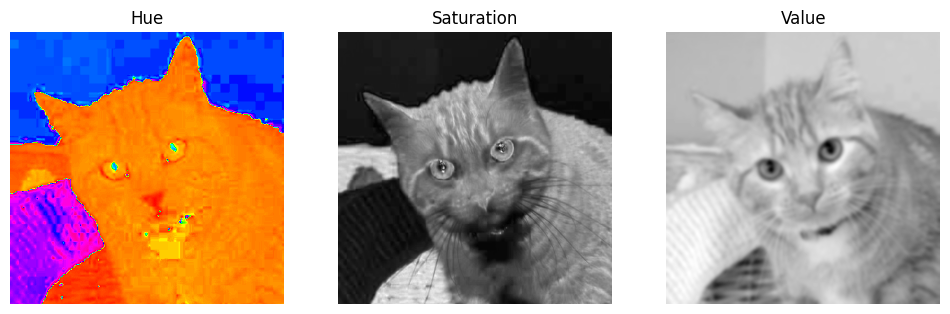

In [ ]:
from skimage import io, color
import matplotlib.pyplot as plt
import cv2

# Load a color image
image = io.imread('/content/cat/194.jpg')

# Convert the image to HSV
image_hsv = color.rgb2hsv(image)

# Split the HSV image into its components (Hue, Saturation, Value)
hue_channel = image_hsv[:, :, 0]
saturation_channel = image_hsv[:, :, 1]
value_channel = cv2.GaussianBlur(image_hsv[:, :, 2], (15, 15), 0)

# Show the three channels of the HSV color space
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(hue_channel, cmap='hsv')
axes[0].set_title('Hue')
axes[0].axis('off')

axes[1].imshow(saturation_channel, cmap='gray')
axes[1].set_title('Saturation')
axes[1].axis('off')

axes[2].imshow(value_channel, cmap='gray')
axes[2].set_title('Value')
axes[2].axis('off')

plt.show()


LAB (CEILAB) channels

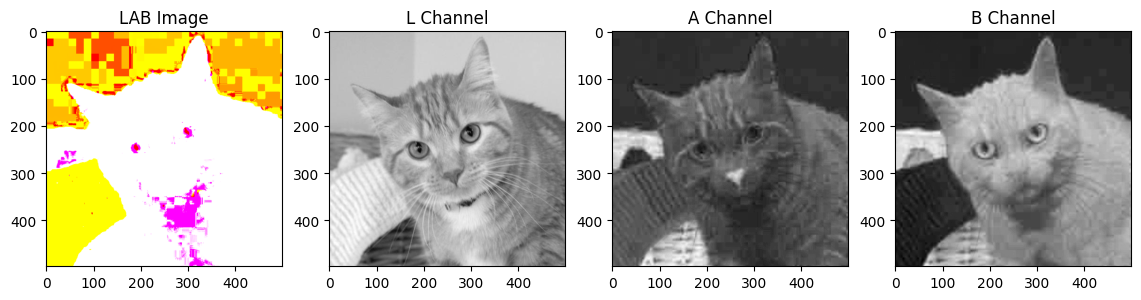

In [ ]:
from skimage import color

# Load a color image
image = io.imread('/content/cat/194.jpg')

# Convert the image from RGB to LAB color space
lab_image = color.rgb2lab(image)

# Split the LAB image into its components
L_channel = lab_image[:, :, 0]
A_channel = lab_image[:, :, 1]
B_channel = lab_image[:, :, 2]

# Show the LAB image and its components
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

axes[0].imshow(lab_image)
axes[0].set_title('LAB Image')

axes[1].imshow(L_channel, cmap='gray')
axes[1].set_title('L Channel')

axes[2].imshow(A_channel, cmap='gray')
axes[2].set_title('A Channel')

axes[3].imshow(B_channel, cmap='gray')
axes[3].set_title('B Channel')

plt.show()

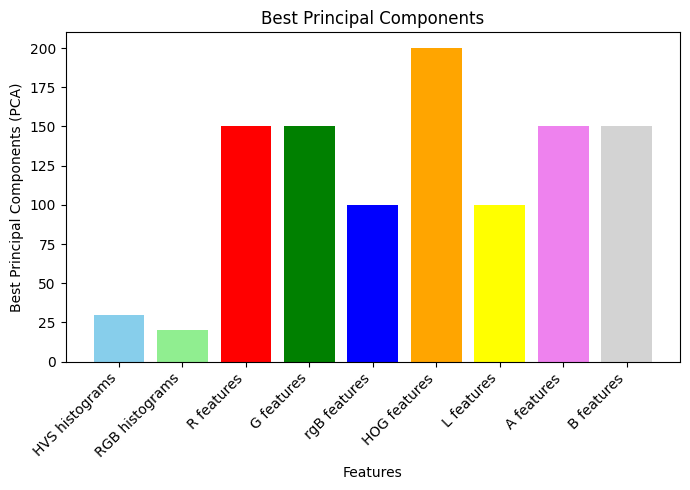

In [66]:
import matplotlib.pyplot as plt

# Features and their corresponding best principal components
features = ['HVS histograms', 'RGB histograms', 'R features', 'G features', 'rgB features', 'HOG features', 'L features', 'A features', 'B features']
best_pca = [30, 20, 150, 150, 100, 200, 100, 150, 150]
colors = ['skyblue', 'lightgreen', 'red', 'green', 'blue', 'orange', 'yellow', 'violet', 'lightgrey']

# Create the bar chart
plt.figure(figsize=(7, 5))
plt.bar(features, best_pca, color=colors)
plt.xlabel('Features')
plt.ylabel('Best Principal Components (PCA)')
plt.title('Best Principal Components')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



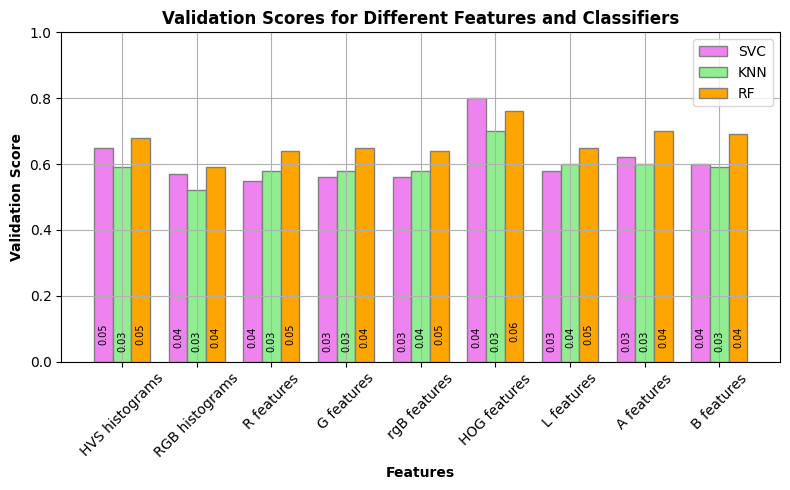

In [65]:
import matplotlib.pyplot as plt

# Data for validation scores
data = {
    'Features': ['HVS histograms', 'RGB histograms', 'R features', 'G features', 'rgB features', 'HOG features', 'L features', 'A features', 'B features'],
    'SVC': [0.65, 0.57, 0.55, 0.56, 0.56, 0.80, 0.58, 0.62, 0.60],
    'KNN': [0.59, 0.52, 0.58, 0.58, 0.58, 0.70, 0.60, 0.60, 0.59],
    'RF': [0.68, 0.59, 0.64, 0.65, 0.64, 0.76, 0.65, 0.70, 0.69]
}
textbar = {
    'Features': ['HVS histograms', 'RGB histograms', 'R features', 'G features', 'rgB features', 'HOG features', 'L features', 'A features', 'B features'],
    'SVC': [0.05, 0.04, 0.04, 0.03, 0.03, 0.04, 0.03, 0.03, 0.04],
    'KNN': [0.03, 0.03, 0.03, 0.03, 0.04, 0.03, 0.04, 0.03, 0.03],
    'RF': [0.05, 0.04, 0.05, 0.04, 0.05, 0.06, 0.05, 0.04, 0.04]
}
colors = ['orange',  'violet', 'lightgreen']

# Get the number of features
num_features = len(data['Features'])

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = range(num_features)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the histogram using Matplotlib
plt.figure(figsize=(8, 5))
for i, feature in enumerate(data['Features']):
    plt.bar(r1[i], data['SVC'][i], color=colors[1], width=bar_width, edgecolor='grey', label='SVC' if i == 0 else None)
    plt.bar(r2[i], data['KNN'][i], color=colors[2], width=bar_width, edgecolor='grey', label='KNN' if i == 0 else None)
    plt.bar(r3[i], data['RF'][i], color=colors[0], width=bar_width, edgecolor='grey', label='RF' if i == 0 else None)

    # Add comments over each bar
    plt.text(r1[i], textbar['SVC'][i], f'{textbar["SVC"][i]:.2f}', ha='center', va='bottom', fontsize=7, rotation=90)
    plt.text(r2[i], textbar['KNN'][i], f'{textbar["KNN"][i]:.2f}', ha='center', va='bottom', fontsize=7, rotation=90)
    plt.text(r3[i], textbar['RF'][i], f'{textbar["RF"][i]:.2f}', ha='center', va='bottom', fontsize=7, rotation=90)
# Add labels, title, and legend

# Set y-axis limits from 0 to 1
plt.ylim(0, 1)

# Add grid
plt.grid(True)
plt.xlabel('Features', fontweight='bold')
plt.xticks([r + bar_width for r in range(num_features)], data['Features'], rotation=45)
plt.ylabel('Validation Score', fontweight='bold')
plt.title('Validation Scores for Different Features and Classifiers', fontweight='bold')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

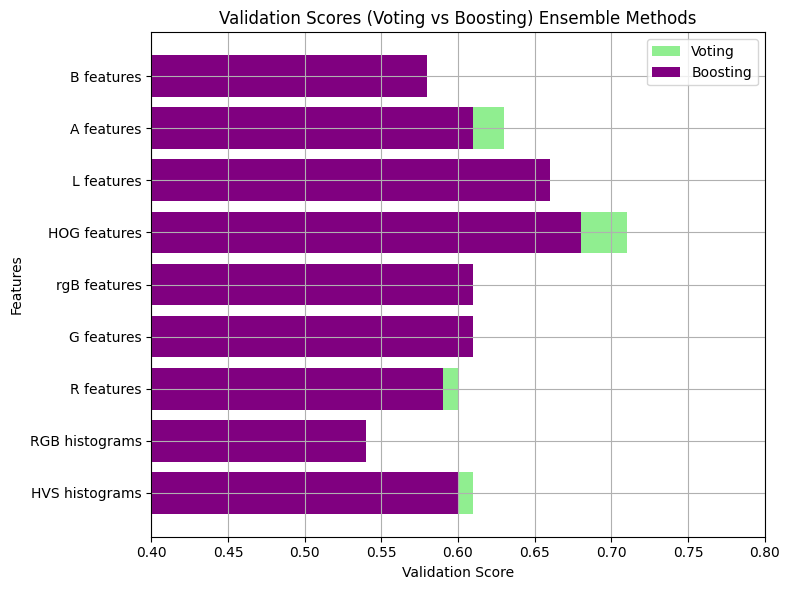

In [63]:
import matplotlib.pyplot as plt

# Data for validation scores
data = {
    'Features': ['HVS histograms', 'RGB histograms', 'R features', 'G features', 'rgB features', 'HOG features', 'L features', 'A features', 'B features'],
    'Voting': [0.61, 0.53, 0.6, 0.61, 0.55, 0.71, 0.63, 0.63, 0.55],
    'Boosting': [0.6, 0.54, 0.59, 0.61, 0.61, 0.68, 0.66, 0.61, 0.58]
}

# Find the minimum value for each method
min_voting = min(data['Voting'])
min_boosting = min(data['Boosting'])

# Create custom colors for each feature
colors = ['skyblue', 'purple', 'red', 'green', 'blue', 'orange', 'yellow', 'violet', 'lightgrey']

# Create the bar plot using Matplotlib
plt.figure(figsize=(8, 6))

# Iterate over the features and their validation scores
for i, (feature, voting_score, boosting_score) in enumerate(zip(data['Features'], data['Voting'], data['Boosting'])):
    # Determine the color for the bar
    bar_color = colors[i % len(colors)]
    # Check if the score exceeds the minimum value
    if voting_score > min_voting:
        voting_color = 'lightgreen'
    else:
        voting_color = bar_color
    if boosting_score > min_boosting:
        boosting_color = 'purple'
    else:
        boosting_color = bar_color
    # Plot the bars
    plt.barh(feature, voting_score, color=voting_color, alpha=1, label='Voting' if i == 0 else None)
    plt.barh(feature, boosting_score, color=boosting_color, alpha=1, label='Boosting' if i == 0 else None)
# Set y-axis limits from 0 to 1
plt.xlim(0.4, 0.8)

# Add grid
plt.grid(True)
# Configure the appearance of the plot
plt.xlabel('Validation Score')
plt.ylabel('Features')
plt.title('Validation Scores (Voting vs Boosting) Ensemble Methods')
plt.legend()
plt.tight_layout()
plt.show()



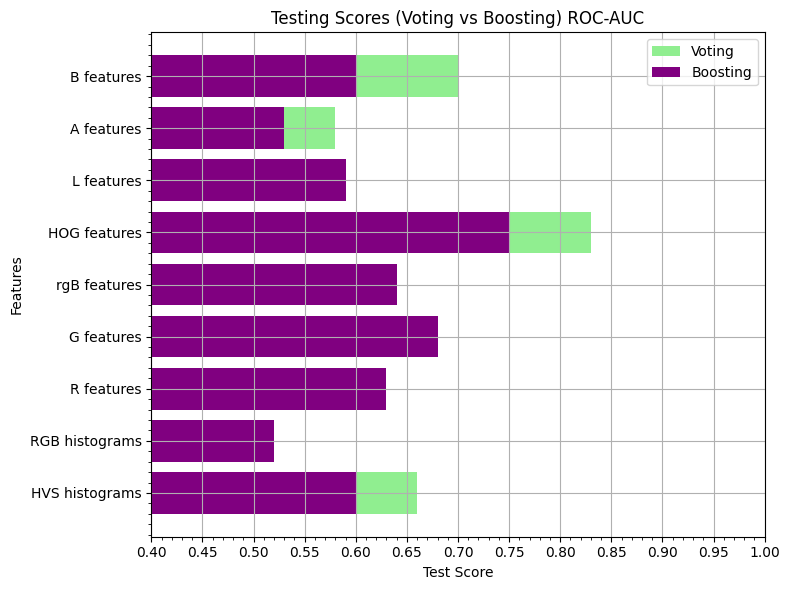

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Data for validation scores
data = {
    'Features': ['HVS histograms', 'RGB histograms', 'R features', 'G features', 'rgB features', 'HOG features', 'L features', 'A features', 'B features'],
    'Voting': [0.66, 0.52, 0.63, 0.66, 0.52, 0.83, 0.57, 0.58, 0.7],
    'Boosting': [0.6, 0.49, 0.63, 0.68, 0.64, 0.75, 0.59, 0.53, 0.6]
}

# Find the minimum value for each method
min_voting = min(data['Voting'])
min_boosting = min(data['Boosting'])

# Create custom colors for each feature
colors = ['skyblue', 'purple', 'red', 'green', 'blue', 'orange', 'yellow', 'violet', 'lightgrey']

# Create the bar plot using Matplotlib
plt.figure(figsize=(8 , 6))

# Iterate over the features and their validation scores
for i, (feature, voting_score, boosting_score) in enumerate(zip(data['Features'], data['Voting'], data['Boosting'])):
    # Determine the color for the bar
    bar_color = colors[i % len(colors)]
    # Check if the score exceeds the minimum value
    if voting_score > min_voting:
        voting_color = 'lightgreen'
    else:
        voting_color = bar_color
    if boosting_score > min_boosting:
        boosting_color = 'purple'
    else:
        boosting_color = bar_color
    # Plot the bars
    plt.barh(feature, voting_score, color=voting_color, alpha=1, label='Voting' if i == 0 else None)
    plt.barh(feature, boosting_score, color=boosting_color, alpha=1, label='Boosting' if i == 0 else None)
# Set y-axis limits from 0 to 1
plt.xlim(0.4, 1)
plt.xticks(np.arange(0.4, 1.05, 0.05))

# Add grid with minor grid lines
plt.grid(True)
plt.minorticks_on()
# Configure the appearance of the plot
plt.xlabel('Test Score')
plt.ylabel('Features')
plt.title('Testing Scores (Voting vs Boosting) ROC-AUC')
plt.legend()
plt.tight_layout()
plt.show()